In [1]:
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from itertools import combinations

import ast
import pickle


In [3]:
class SBS():
    ''' Feature selection via sequential backward selection (SBS)
    estimator : this is the Estimator/Model that we will use to calculate scores 
    k_features : number of minimum features (how many features should be left after we start exluding)
    scoring : calc_metrics (this is a function i have created) but could be accuracy_score
    scoring_metric : recall, precision, accuracy, f_score (default is recall)
    test_size=0.33
    random_state=42
    '''
    def __init__(self, estimator, k_features,
        scoring=accuracy_score, scoring_metric = 'recall',
        test_size=0.33, random_state=42):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        self.scoring_metric = scoring_metric
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        # self.removed_ = []
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        # self.removed_ = [item for item in self.indices_[-1] if item not in X.columns]
        # print('done')
        return self
    def transform(self, X):
        return X[:, self.indices_]
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # print(type(indices),indices)
        self.estimator.fit(X_train.loc[:, indices], y_train)
        y_pred = self.estimator.predict(X_test.loc[:, indices])
        if self.scoring == accuracy_score: 
            score = self.scoring(y_test, y_pred)
            self.scoring_metric = 'Accuracy'
        else: score = self.scoring(metrics.confusion_matrix(y_test, y_pred), self.scoring_metric)
        return score

In [4]:
class SetCategorii:
    """Select the Dataframe for which you want to create categories. The used method is OrdinalEncoder(handle_unknown="error").
    If no dataframe is selected the ordered categories that i have selected manually will be used. (they are specifically for teh Mental Health project)
    
    """
    
    def __init__(self, dataframe = None):
        '''text2'''
        self._dataframe = dataframe
        self._enc = OrdinalEncoder(handle_unknown="error")
        self._categorii = []
        self._features = []
        self._ordered_feature_names = ['Age', 'Gender', 'self_employed', 'family_history', 'treatment', 'no_employees', 'remote_work', 'tech_company', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence',
       'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence',
       'year', 'work_treatment_interfere', 'work_no_treatment_interfere', 'Continent']
        self._ordered_categorii = [np.array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 70], dtype=int),
 np.array(['f', 'other', 'm'], dtype=object),
 np.array(['No', 'Yes'], dtype=object),
 np.array(['No', "I don't know", 'Yes'], dtype=object),
 np.array([0, 1], dtype=int),
 np.array(['1-5', '6-25','26-100','100-500', '500-1000',  'More than 1000'], dtype=object),
 np.array(['Never', 'Sometimes', 'Always'], dtype=object),
 np.array([0., 1.]),
 np.array(['No', 'Not eligible for coverage / N/A', "Don't know", 'Yes'], dtype=object),
 np.array(['No', 'Not sure', 'Yes'], dtype=object),
 np.array(['No', "Don't know", 'Yes'], dtype=object),
 np.array(['No', "Don't know", 'Yes'], dtype=object),
 np.array(['No', "Don't know", 'Yes'], dtype=object),
 np.array(['Very difficult', 'Somewhat difficult', 'Neither easy nor difficult', "Don't know", 'Somewhat easy',  'Very easy'], dtype=object),
 np.array(['No', 'Maybe', 'Yes'], dtype=object),
 np.array(['No', 'Maybe', 'Yes'], dtype=object),
 np.array(['No', 'Maybe', 'Some of them', 'Yes'], dtype=object),
 np.array(['No', 'Maybe', 'Some of them', 'Yes'], dtype=object),
 np.array(['No', 'Maybe', 'Yes'], dtype=object),
 np.array(['No', 'Maybe', 'Yes'], dtype=object),
 np.array(['No', "Don't know", 'Yes'], dtype=object),
 np.array([0., 1.]),
 np.array(['Never', 'Rarely', 'Not applicable to me', 'Sometimes', 'Often'], dtype=object),
 np.array(['Never', 'Rarely', 'Not applicable to me', 'Sometimes', 'Often'], dtype=object),
 np.array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'], dtype=object)]
        
        self.fit(dataframe)
        
    def fit(self, dataframe = None):
        ''' Create categorii from the dataframe, 
        if no dataframe is given we will work with the ordered categorii i created for my particular case'''
        dataframe = self._dataframe
        if type(dataframe) == pd.DataFrame:
            self._enc.fit(dataframe)
            self._categorii = self._enc.categories_
            self._features = self._enc.feature_names_in_.tolist()
        else:
            self._categorii = self._ordered_categorii
            self._features = self._ordered_feature_names
        
    
    def check_gategorii(self,feature = [], num = "no"):
        ''' num = you can address the features by number of the column or name of teh column. The default is 'no' - meaning by the name of the column'''
        if num == 'yes' : 
            if all(ele < len(self._features) for ele in feature):
                feature = [self._features[i] for i in feature]
            else: 
                return print('Wrong Feature numbers')
        if len(feature) == 0:
            data = {self._features[i]: list(self._categorii[i]) for i in range(len(self._features))}
            return data
        else:
            if all(ele in self._features for ele in feature) == False:
                return print('Wrong Feature names')
            data = {i : list(self._categorii[self._features.index(i)]) for i in feature}
            # data = self._features
            # print(type(data))
            return data
            
    def change_categorii_order(self, feature = []):
        ''' if no features are mentioned it will prompt teh change of all features
        Features can be listed only as column names'''
        if feature == [] : feature = self._features
        for i in self.check_gategorii(feature).keys():
            print(f' Please provide a list of the desired order:\n Example : [\'m\',\'f\',\'other\'] \n Categories for column {i} are as follows. \n {self.check_gategorii([i]).values()}')
            data =  input()
            data = ast.literal_eval(data)
            if all(ele in self._categorii[self._features.index(i)] for ele in data) == False:
                return print('Wrong categorie names')
            self._categorii[self._features.index(i)] = np.array(data)
            
        return self.check_gategorii(feature)

    def get(self):
        return self._categorii

In [5]:
def create_categor_dataset(dataset, categorii = 'auto'):
    '''This will convert categorical columns using OrdinalEncoder with a pre-defined Ordering on the values(categories) in each column'''
    dataset = dataset.copy()
    enc = OrdinalEncoder(handle_unknown="error", categories = categorii)
    dataset = enc.fit_transform(dataset)
    return pd.DataFrame(dataset, columns= enc.feature_names_in_)

def compare_matrix(matrix1, matrix2, abs = 'no'):
    ''' this will compare matrix1 and matrix 2 by subtracting the values in the 2 matrixes cell by cell in the format matrix1 - matrix2.
    matrix1 = first matrix (subtract from)
    matrix2 = second matrix
    abs =  note if the values should be in absolute values, default is 'no'. if 'yes' the values wil be in absolute values
    '''
    compare = matrix1 - matrix2
    plt.figure(figsize=(18, 16))
    sns.heatmap(compare, annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap")
    plt.xticks(rotation = 75)
    return plt.show()

def plot_heatmap(correlation_matrix):
    '''plots a heatmap given a matrix'''
    plt.figure(figsize=(18, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation Heatmap")
    plt.xticks(rotation = 75)
    plt.show()

def check_answers(dataset, feature =[]):
    ''' provide the unique answers for a feature in a dataset.
    Features should be list like'''
    for i in feature :
        print('Unique values for "{}"'.format(i))
        print(dataset[i].unique())
        print('---------------------------------------------------------------------------------\n')

def getting_x_y(dataframe):
    '''Givven a Dataframe for our scenario, this will provide:
    X = intependant variables (NOT scaled)
    X_norm = Independant variables (Scaled with StandardScaler)
    y  = dependant variable'''
    scaler = StandardScaler()
    data_norm =  pd.DataFrame(scaler.fit_transform(dataframe), columns= dataframe.columns)
    X_norm = data_norm.drop('treatment', axis = 1)
    X = dataframe.drop('treatment', axis = 1)
    y = dataframe['treatment']
    return X_norm, X, y

def calc_metrics(matrix, score):
    '''Thgis needs a correlation Martix and will return one of the available scores. The function is build to facilitate tests.
    score = recall, precision, accuracy, f_score
    
    '''
    tp = matrix[1][1]
    fn = matrix[1][0]
    tn = matrix[0][0]
    fp = matrix[0][1]
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    f_score =2*(precision*recall)/(precision+recall)
    scores = {'recall' : recall, 'precision': precision, 'accuracy' : accuracy, 'f_score' : f_score}
    return scores[score]

def cross_valid_mean(model, X, y, scoring = ['recall', 'f1'], cv = 5):
    '''
    This will help us compare the means of the CV between diffeent models.
    
    cv = Determines the cross-validation splitting strategy. (default = 5)
    scoring = Strategy to evaluate the performance of the cross-validated model on the test set. (default = ['recall', 'f1'])
    '''
    model_cvm_mean = {}
    model = model
    model_cvm = cross_validate(model, X, y, scoring= scoring, cv = cv)
    for i in model_cvm:
        model_cvm_mean[i] = model_cvm[i].mean()
    return model_cvm_mean

def tomi_make_pipe(columns,  model_name):
    ''' As we are using the same Column transformation but intend to test different pipelines. 
    This function will help us save some time, and will keep the code clean 
    for the column "Age" we use StandardScaler.
    for the rest of the columns that are categorical we use OneHotEncoder
    columns : those are teh columns that will be used by the model
    model_name : this is teh model used for this pipeline
    '''
    cat_col = [i for i in columns if i not in ['Age','treatment']]
    num_col = ['Age']
    target='treatment'
    pl_scaler = StandardScaler()
    pl_encoder = OneHotEncoder()
# putting numeric columns to scaler and categorical to encoder
    num_transformer = make_pipeline(pl_scaler)
    cat_transformer = make_pipeline(pl_encoder)
# getting together our scaler and encoder with preprocessor
    preprocessor = ColumnTransformer(
        transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# giving all values to pipeline
    # return make_pipeline(preprocessor,model_name)
    return Pipeline([('preproc',preprocessor),('est',model_name)])

def partial_pipe_fit(pipeline_obj, x, y):
    # here we use .transform because in the new dataset we might have some categorical answers missing and we don't want this to affect our pipeline
    X = pipeline_obj.named_steps['preproc'].transform(x)
    # print(X.shape) # for testing purposes
    Y = y
    pipeline_obj.named_steps['est'].partial_fit(X,Y)

# Mental health in the Tech industry - Prediction
   ### by Tomislav Vasilev

This project is continuation of my previous project "Mental health in the Tech industry". I want to work on the Dataset i had previously created and expand its scope. <br>




## Abstract

We will have the assumption that the participants in each year were part of different and independent sets of participants and there is no overlapping between them.<br>
The dataset used for the initial training has been pre-processed in my previous Project "Mental health in the Tech industry". From there we know our dataset is relatively balanced and we should treat it as a balanced problem.<br>


In this project we will:<br>
1. Try to create a predictive model that is able to determine if an individual has looked for help based on the environment and conditions of his work (or at least how the individual perceives and picture this environment through the questions asked). We will experiment with a couple of different approaches<br>
If our model manages to give a proper prediction result. We can focus on the False Positive results, as those might be people who need help but have not yet addressed it.<br>
2. We will create a pipeline<br>
3. We will get new data for the year 2017 and:<br>
    3.1. train our model on 2014/2016 and test it on 2017<br>
    3.2. apply continues training on our model with 2017 and test it on 2017 using Incremental training<br>



## References

[Feature-selection-using-regularisation](https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499)<br>
<b>Python Machine Learning</b> by Sebastian Raschka and Vahid Mirjalilin<br>
[Building a Machine Learning Pipeline with Scikit-Learn](https://towardsdatascience.com/building-a-machine-learning-pipeline-3bba20c2352b)<br>
[Are you sure that's a probability?](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html)

<a id='topi'></a>
## Content

* [Loading and Reviewing the Data](#ld)
* [Feature encoding and Correlation Matrix](#encoding)
* [Choose the right metrics and Features](#metrics)
    * [Feature selection via Lasso](#lasso)
    * [Feature selection via sequential backward selection (SBS)](#sbs)
    * [Feature selection via Random Forest](#forest)
    * [Choosing the features to remove](#choose)
* [Choosing Dataset and Models](#choose_data)
* [Fine Tuning the Models (GridSearchCV is used here and the code is #commented to avoid time delay in case all the cells are run)](#tune)
* [PCA, Bagging and Boosting ?](#pca)
* [Creating PipeLine](#pipeline)
* [Use the data from 2017 as a test set](#2017)
* [ROC curve for Random Forest](#roc)
* [Create pickle file](#pickle)
* [Incremental learning](#online-learn)
* [Conclusion](#con)

[TOP](#topi)

## Loading and Reviewing the Data
Let us load the dataset and remind ourselves what were the features.

### Legend of the columns

<b>'Age'			:</b> Age<br>
<b>'Gender'		:</b> Gender<br>
<b>'self_employed'	:</b> Are you self-employed?<br>
<b>'family_history':</b> Do you have a family history of mental illness?<br>
<b>'treatment'		:</b> Have you sought treatment for a mental health condition?<br>
<b>'no_employees'	:</b> How many employees does your company or organization have?<br>
<b>'remote_work'	:</b> Do you work remotely (outside of an office) at least 50% of the time?<br>
<b>'tech_company'	:</b> Is your employer primarily a tech company/organization?<br>
<b>'benefits'		:</b> Does your employer provide mental health benefits?<br>
<b>'care_options'	:</b> Do you know the options for mental health care your employer provides?<br>
<b>'wellness_program' :</b> Has your employer ever discussed mental health as part of an employee wellness program?<br>
<b>'seek_help'		:</b> Does your employer provide resources to learn more about mental health issues and how to seek help?<br>
<b>'anonymity'		:</b> Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?<br>
<b>'leave'			:</b> How easy is it for you to take medical leave for a mental health condition?<br>
<b>'mental_health_consequence' :</b> Do you think that discussing a mental health issue with your employer would have negative consequences?<br>
<b>'phys_health_consequence' :</b> Do you think that discussing a physical health issue with your employer would have negative consequences?<br>
<b>'coworkers' 	:</b> Would you be willing to discuss a mental health issue with your coworkers?<br>
<b>'supervisor' 	:</b> Would you be willing to discuss a mental health issue with your direct supervisor(s)?<br>
<b>'mental_health_interview ':</b> Would you bring up a mental health issue with a potential employer in an interview?<br>
<b>'phys_health_interview' :</b> Would you bring up a physical health issue with a potential employer in an interview?<br>
<b>'mental_vs_physical' :</b> Do you feel that your employer takes mental health as seriously as physical health?<br>
<b>'obs_consequence' :</b> Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?<br>
<b>'work_treatment_interfere':</b> If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?<br>
<b>'work_no_treatment_interfere':</b> If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively? <br>
<b>'Continent':</b> The continent where the participant lives

In [6]:
# We are loading the data in the state just before executing the categorical features encoding 
# that was needed to start applying a Prediction models.
al_mental = pd.read_csv('14_16_pre_Encoder.csv')
# we will remove the 'year' feature as we don't want our model to depend on that
al_mental = al_mental.drop('year', axis = 1)
al_mental.head(3)

,Age,Gender,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,care_options,...,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,work_treatment_interfere,work_no_treatment_interfere,Continent
0,37,f,No,No,1,6-25,Never,1.0,Yes,Not sure,...,No,Some of them,Yes,No,Maybe,Yes,0.0,Often,Often,North America
1,44,m,No,No,0,More than 1000,Never,0.0,Don't know,No,...,No,No,No,No,No,Don't know,0.0,Rarely,Rarely,North America
2,32,m,No,No,0,6-25,Never,1.0,No,No,...,No,Yes,Yes,Yes,Yes,No,0.0,Rarely,Rarely,North America


[TOP](#topi)

<a id='encoding'></a>
## Feature encoding and Correlation Matrix
We will notice that the correlation matrix looks different, depending on that how we encoded the features and what correlation methods are used: 

As we are only interested in the "treatment" feature and to save some space i will show only the correlation between treatment and the other features.

We will create the following Matrices with the categorical data converted to numbers:
1. *_def_correlation_matrix   - convert the categories of the features without ordering the answers
2. *_mid_correlation_matrix   - convert the categories of the features by ordering the answers (from 'bad' to 'good') so that "don't know", "Other"  are in the middle
3. *_left_correlation_matrix  - convert the categories of the features by ordering the answers(from 'bad' to 'good') so that "don't know", "Other"  are on the left
4. *_right_correlation_matrix - convert the categories of the features by ordering the answers(from 'bad' to 'good') so that "don't know", "Other"  are on the right

We will also use two different correlation methods : 'kendall', 'pearson' and 'spearman'

In [7]:
# Lets create the categories
def_categorii = SetCategorii(al_mental).get()
mid_categorii = SetCategorii().get()

In [8]:
# I have already played with the categories and as configuring new categories requires input, i will set the values directly. 
# Playing with the order of categories combined with understanding of how the correlation methods work might result in some fun time :)

left_categorii = [np.array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 70], dtype=int), np.array([ 'other', 'f', 'm'], dtype=object), np.array(['No', 'Yes'], dtype=object), np.array(["I don't know", 'No', 'Yes'], dtype=object), np.array([0, 1], dtype=int), np.array(['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000'], dtype=object), np.array(['Never', 'Sometimes', 'Always'], dtype=object), np.array([0., 1.]), np.array(["Don't know", 'Not eligible for coverage / N/A', 'No', 'Yes'], dtype=object), np.array(['Not sure', 'No', 'Yes'], dtype=object), np.array(["Don't know", 'No', 'Yes'], dtype=object), np.array(["Don't know", 'No', 'Yes'], dtype=object), 
                  np.array(["Don't know", 'No', 'Yes'], dtype=object), np.array(["Don't know", 'Very difficult', 'Somewhat difficult', 'Neither easy nor difficult', 'Somewhat easy', 'Very easy'], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Some of them', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Some of them', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(["Don't know", 'No', 'Yes'], dtype=object), np.array([0., 1.]), np.array(['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'], dtype=object), np.array(['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'], dtype=object), np.array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'], dtype=object)]

right_categorii = [np.array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 70], dtype=int), np.array(['f', 'm', 'other'], dtype=object), np.array(['No', 'Yes'], dtype=object), np.array(['No', 'Yes', "I don't know"], dtype=object), np.array([0, 1], dtype=int), np.array(['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000'], dtype=object), np.array(['Never', 'Sometimes', 'Always'], dtype=object), np.array([0., 1.]), np.array(['Not eligible for coverage / N/A', 'No', 'Yes', "Don't know"], dtype=object), np.array(['No', 'Yes', 'Not sure'], dtype=object), np.array(['No', 'Yes', "Don't know"], dtype=object), np.array(['No', 'Yes', "Don't know"], dtype=object), 
                   np.array(['No', 'Yes', "Don't know"], dtype=object), np.array(['Very difficult', 'Somewhat difficult', 'Neither easy nor difficult', 'Somewhat easy', 'Very easy', "Don't know"], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Some of them', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Some of them', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(['No', 'Maybe', 'Yes'], dtype=object), np.array(['No', 'Yes', "Don't know"], dtype=object), np.array([0., 1.]), np.array(['Never', 'Rarely', 'Sometimes', 'Often', 'Not applicable to me'], dtype=object), np.array(['Never', 'Rarely', 'Sometimes', 'Often', 'Not applicable to me'], dtype=object), np.array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'], dtype=object)]

In [9]:
# Convert the dataset according to those categories 
def_categorii_data = create_categor_dataset(al_mental, categorii= def_categorii)
mid_categorii_data = create_categor_dataset(al_mental, categorii= mid_categorii)
left_categorii_data = create_categor_dataset(al_mental, categorii= left_categorii)
right_categorii_data = create_categor_dataset(al_mental, categorii= right_categorii)

# Create the correlation matrix for each with method= 'kendall'
k_def_correlation_matrix = def_categorii_data.corr(method= 'kendall' , numeric_only = True)
k_mid_correlation_matrix = mid_categorii_data.corr(method= 'kendall' , numeric_only = True)
k_left_correlation_matrix = left_categorii_data.corr(method= 'kendall' , numeric_only = True)
k_right_correlation_matrix = right_categorii_data.corr(method= 'kendall' , numeric_only = True)


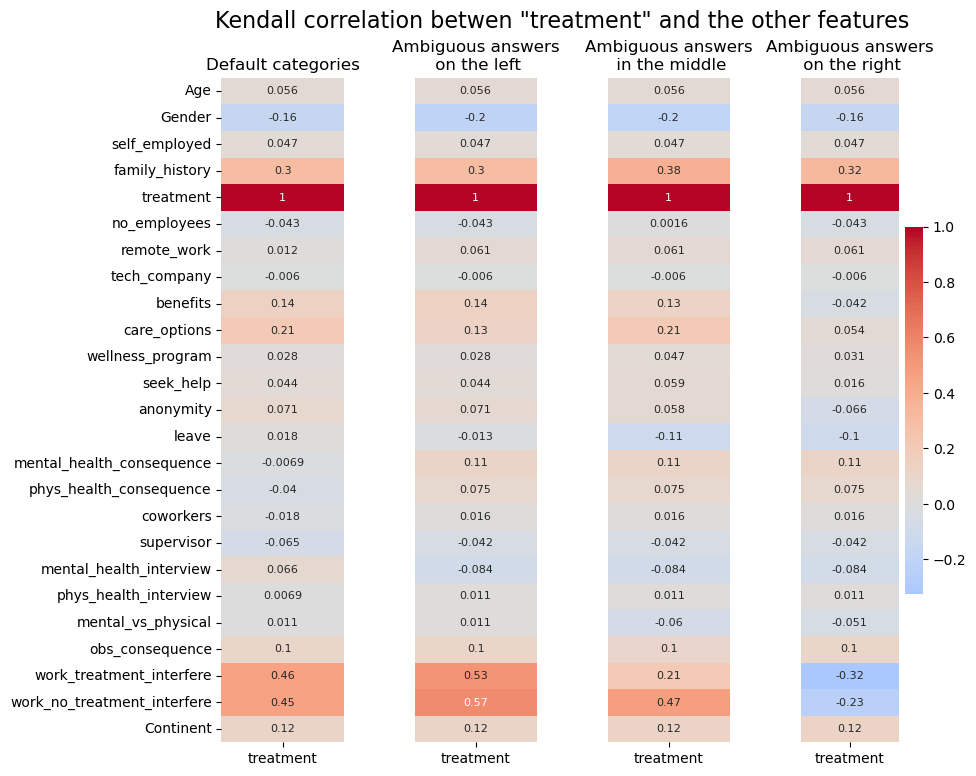

In [10]:
#plot the correlation matrices in respect to "treatment"
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(8, 8))

fig.suptitle('Kendall correlation betwen "treatment" and the other features', fontsize=16)
fig.tight_layout(pad=2.0)

g1 = sns.heatmap(k_def_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax1, cbar = False)
g1.set_title( label = f'Default categories')

g2 = sns.heatmap(k_left_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax2, yticklabels=False, cbar = False)
g2.set_title( label = f'Ambiguous answers\n on the left')

g3 = sns.heatmap(k_mid_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax3, yticklabels=False, cbar = False)
g3.set_title( label = f'Ambiguous answers\n in the middle')

g4 = sns.heatmap(k_right_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax4, yticklabels=False, cbar = True)
g4.set_title( label = f'Ambiguous answers\n on the right')

plt.show()

We can see there a some Features where order really changes the magnitude of the calculated relation. We are not so interested in the sign (positive or negative), but rather in the strength of the relation, as this will most probably affect the way some of the prediction models work. Bellow are show the answers for features mostly affected by the order.<br><br>
We can identify that "Left" and "Middle" approach are better that the "Right one". From the "Kendall" method i select the left.

In [11]:
check_answers(al_mental,['remote_work', 'mental_health_consequence','mental_vs_physical', 'work_treatment_interfere', 'work_no_treatment_interfere', 'leave'])

Unique values for "remote_work"
['Never' 'Sometimes' 'Always']
---------------------------------------------------------------------------------

Unique values for "mental_health_consequence"
['No' 'Maybe' 'Yes']
---------------------------------------------------------------------------------

Unique values for "mental_vs_physical"
['Yes' "Don't know" 'No']
---------------------------------------------------------------------------------

Unique values for "work_treatment_interfere"
['Often' 'Rarely' 'Never' 'Sometimes' 'Not applicable to me']
---------------------------------------------------------------------------------

Unique values for "work_no_treatment_interfere"
['Often' 'Rarely' 'Never' 'Sometimes' 'Not applicable to me']
---------------------------------------------------------------------------------

Unique values for "leave"
['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy' 'Neither easy nor difficult']
------------------------------------

In [12]:
# Now lets compare the "Left Kendall" method with the "Pearson method" and "Spearman method"
s_left_correlation_matrix = left_categorii_data.corr(method= 'spearman' , numeric_only = True)
p_left_correlation_matrix = left_categorii_data.corr(method= 'pearson' , numeric_only = True)
p_mid_correlation_matrix = mid_categorii_data.corr(method= 'pearson' , numeric_only = True)

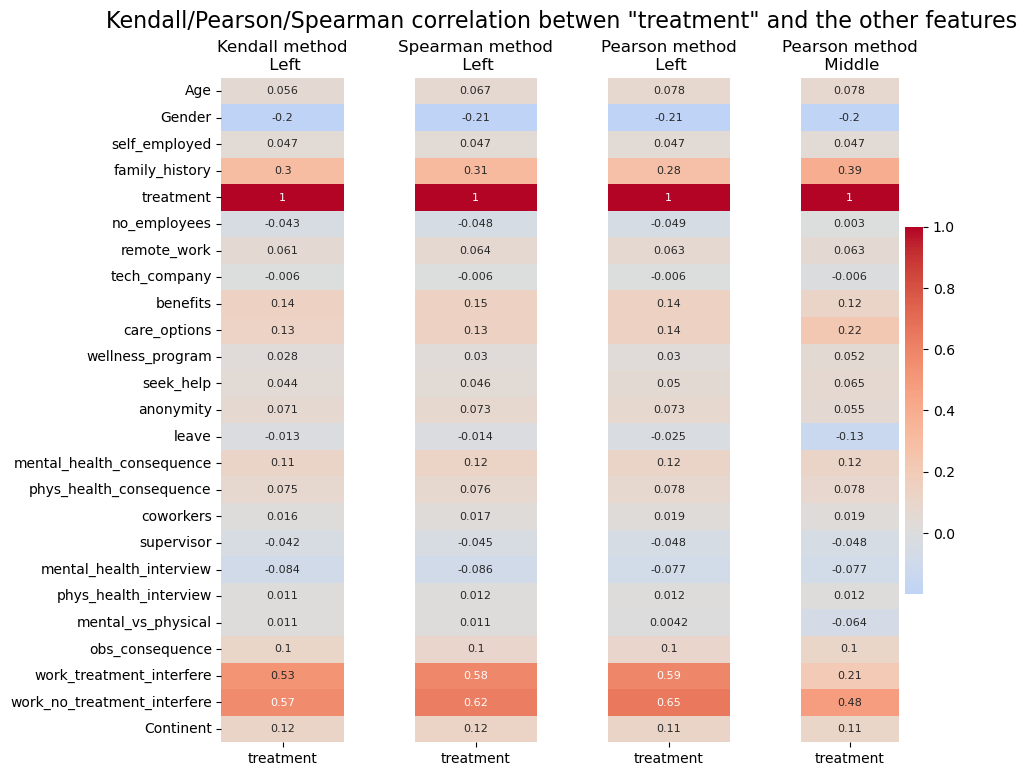

In [13]:
#plot the correlation matrices in respect to "treatment"
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(8, 8))

fig.suptitle('Kendall/Pearson/Spearman correlation betwen "treatment" and the other features', fontsize=16)
fig.tight_layout(pad=2.0)

g1 = sns.heatmap(k_left_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax1, cbar = False)
g1.set_title( label = f'Kendall method\n Left')

g2 = sns.heatmap(s_left_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax2, yticklabels=False, cbar = False)
g2.set_title( label = f'Spearman method\n Left')

g3 = sns.heatmap(p_left_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax3, yticklabels=False, cbar = False)
g3.set_title( label = f'Pearson method\n Left')

g4 = sns.heatmap(p_mid_correlation_matrix[['treatment']], annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8}, fmt = '.2g', ax = ax4, yticklabels=False, cbar = True)
g4.set_title( label = f'Pearson method\n Middle')

plt.show()

Again the "Left" and "Middle" approach are better (This of course has all to do with the way those methods calculate correlations.).<br> <b>I will keep the categorically encoded dataset where the ambiguous answers are on the Left!

[TOP](#topi)
<a id='metrics'></a>
# Choose the right metrics and Features

We want to create a model that predicts who of our participants has asked for help based on the conditions he is working in. Our ultimate goal is to find individuals who might need help but still haven't asked for it, as those would be the people we have to address in the future and try to help them.<br>
Thus lets make up our minds what we want our model to do:<br>
1. We want high <b>Recall</b> - meaning we want to mach all the people who has asked for a treatment.
2. We can accept medium Precision as this could mean we have identified people who need help but haven't looked for it yet - those False Positives might need to become True Positives 
3. Accuracy is still a good measure, we want to have high Accuracy, but it is really the Recall that i think we should try to improve!
4. <b>F-score</b> is also good measure as it takes under consideration the recall and precision

In [14]:
l_X_norm, l_X, y = getting_x_y(left_categorii_data)

[TOP](#topi)
<a id='lasso'></a>
### Feature Selection via Lasso

We will use Logistic regression as This is one of the models i have considered appropriate for the task. Further in the project we will discuss the Models i have selected.

In [15]:
# By decreasing C, we increase the regularization alpha => thus reducing more and more features(making them less important). Bellow are listed the the features that we can skip, based on the level of regularization
for i in [0.3,0.2,0.1,0.05, 0.01]:
    sel = SelectFromModel(estimator = LogisticRegression(C=i, class_weight= None, dual = False, fit_intercept= True, intercept_scaling= 1 , 
    max_iter= 100, multi_class= 'ovr', n_jobs=1, random_state=42, tol= 0.0001, verbose=0, warm_start= False, penalty='l1', solver = 'liblinear'),
    prefit=False, threshold=None)
    sel.fit(l_X_norm, y)
    rfl1 = l_X_norm.columns[(sel.estimator_.coef_ == 0).ravel().tolist()]
    print(f'For regularization L1 with C = {i}, we can remove the following features: {list(rfl1)}')
    print(20*'-')
    if i == 0.05 : removed_features_l1 = list(rfl1)

For regularization L1 with C = 0.3, we can remove the following features: ['self_employed']
--------------------
For regularization L1 with C = 0.2, we can remove the following features: ['self_employed', 'leave']
--------------------
For regularization L1 with C = 0.1, we can remove the following features: ['self_employed', 'leave', 'mental_health_consequence', 'mental_health_interview']
--------------------
For regularization L1 with C = 0.05, we can remove the following features: ['self_employed', 'tech_company', 'seek_help', 'leave', 'mental_health_consequence', 'coworkers', 'mental_health_interview', 'obs_consequence']
--------------------
For regularization L1 with C = 0.01, we can remove the following features: ['Age', 'self_employed', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_h

[TOP](#topi)

<a id='sbs'></a>
## Feature selection via sequential backward selection (SBS)

A classic sequential feature selection algorithm is sequential backward selection (SBS), which aims to reduce the dimensionality of the initial feature subspace with minimum decay in the performance of the classifier to improve upon computation l efficiency. In certain cases, SBS can even improve the predictive power of the model if a model suffers overfit.

I don't want to remove more than 30% of the features, as i am just not feeling comfortable with the idea of removing too many features. Thus i will run the SBS with the desire to leave at least 16 features in.

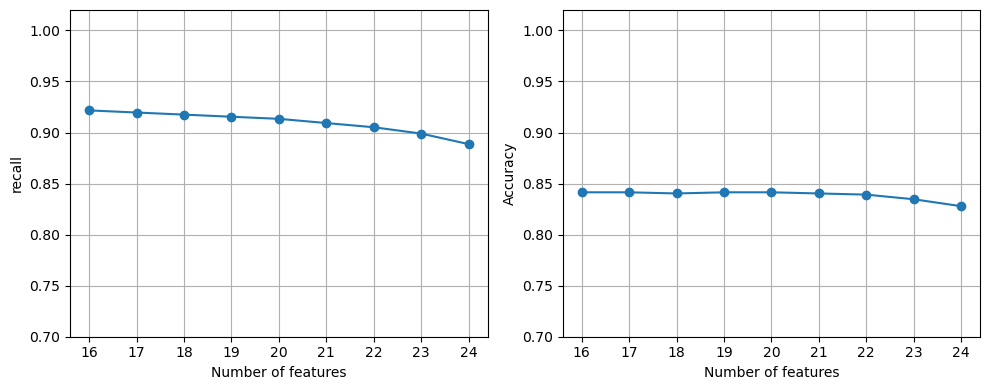

In [16]:
# I want to rename the Column names to numbers so that i can easily execute the script
X_sbs = l_X_norm.copy()
X_sbs.columns = [i for i in range(X_sbs.shape[1])]

# I will use again Logistic regression
lg_sbs = LogisticRegression()
sbs = SBS(lg_sbs, k_features=16, scoring = calc_metrics, scoring_metric= 'recall')
sbs_accuracy = SBS(lg_sbs, k_features=16)
sbs.fit(X_sbs, y)
sbs_accuracy.fit(X_sbs, y)

# and will plot the results
k_feat = [len(k) for k in sbs.subsets_]
k_feat_a = [len(k) for k in sbs_accuracy.subsets_]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(k_feat, sbs.scores_, marker='o')
ax1.set_ylim([0.7, 1.02])
ax1.set_ylabel(f'{sbs.scoring_metric}')
ax1.set_xlabel('Number of features')
ax1.grid()

ax2.plot(k_feat, sbs_accuracy.scores_, marker='o')
ax2.set_ylim([0.7, 1.02])
ax2.set_ylabel(f'{sbs_accuracy.scoring_metric}')
ax2.set_xlabel('Number of features')
ax2.grid()

plt.tight_layout()  

plt.show()

<b> Please keep in mind that based on the Metric we use as a scoring metric, different features might get removed.<br>
Meaning that the 16 features kept with metric = Recall are are different from the 16 features with metric = Accuracy</b><br>
I have also checked the F_score and it stays stable.

In [17]:
# removed features with metric = Recall:
removed_features_sbs = [i for i in X_sbs.columns if i not in sbs.subsets_[-1]]
removed_features_sbs = list(l_X_norm.columns[removed_features_sbs])
print(len(removed_features_sbs), removed_features_sbs)

8 ['Age', 'Gender', 'family_history', 'mental_health_consequence', 'supervisor', 'mental_health_interview', 'mental_vs_physical', 'Continent']


In [18]:
# Kept features with metric = Recall
kept_features_sbs = list(sbs.subsets_[-1])
print(len(l_X_norm.columns[kept_features_sbs]),list(l_X_norm.columns[kept_features_sbs]))

16 ['self_employed', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'phys_health_consequence', 'coworkers', 'phys_health_interview', 'obs_consequence', 'work_treatment_interfere', 'work_no_treatment_interfere']


[TOP](#topi)
<a id='forest'></a>
### Feature Selection via Random Forest

Random Forest is very good Model to be used when most of the data is categorical, thus we will definitely test a RF model. Using 
a random forest, we can measure the feature importance as the averaged impurit 
decrease computed from all decision trees in the fore.st

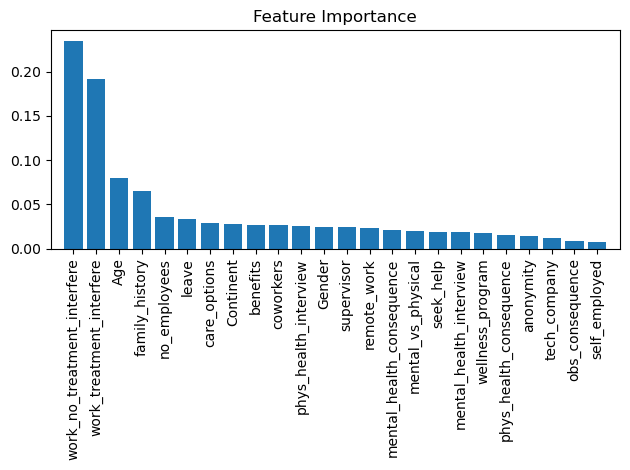

In [19]:
feat_labels = l_X.columns
removed_features_rf = []
forest = RandomForestClassifier(n_estimators=500, random_state=42)
l_X_train, l_X_test, l_y_train, l_y_test = train_test_split(l_X, y, test_size=0.33, random_state=42)

forest.fit(l_X_train, l_y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(l_X_train.shape[1]):
    if importances[indices[f]] <0.02 : removed_features_rf.append(feat_labels[indices[f]])
    # print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(l_X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(l_X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, l_X_train.shape[1]])
plt.tight_layout()

In [20]:
for f in range(l_X_train.shape[1]):
    if importances[indices[f]] <0.02 : print(feat_labels[indices[f]])

seek_help
mental_health_interview
wellness_program
phys_health_consequence
anonymity
tech_company
obs_consequence
self_employed


In [21]:
# We can see which are the most important features according to Random Forest Model in the chart above.
# we can see bellow which features are bellow the 0.02 bar of importance I decided to use and could be removed 
list(removed_features_rf)

['seek_help',
 'mental_health_interview',
 'wellness_program',
 'phys_health_consequence',
 'anonymity',
 'tech_company',
 'obs_consequence',
 'self_employed']

[TOP](#topi)
<a id='choose'></a>
### Choosing the features to remove
in conclusion i will cross reference the features from all the results above and will decide. I don't want to remove more than 8 features because i am worried. I don't know why i am worried, but it just feels risky to remove more than 33% of your features, even though for sure there are many Datasets for which this applies.

In [22]:
# print(removed_features_rf)
# print(removed_features_l1)
# print(removed_features_sbs)
rem_f_all = removed_features_rf+removed_features_l1+removed_features_sbs
rem_f_dup = list(set([i for i in rem_f_all if rem_f_all.count(i) > 1]))
print(f'There are {len(set(rem_f_all))} features that are not so important according to the combined information. ')
print(f'The following : {rem_f_dup} \nare duplicated and I feel safe to remove them. Even though they are just {len(rem_f_dup)}, I do believe this is progress :)')

There are 17 features that are not so important according to the combined information. 
The following : ['tech_company', 'mental_health_interview', 'obs_consequence', 'mental_health_consequence', 'seek_help', 'self_employed'] 
are duplicated and I feel safe to remove them. Even though they are just 6, I do believe this is progress :)


<b>I will remove the features mentioned above</b>

[TOP](#topi)
<a id='choose_data'></a>
## Choosing Dataset and Model
So far we have created a Dataset where we encoded the ambiguous answers on the left , thus giving them low value in the encoding. After we have completed the feature reduction i would like to create another Dataset using different Encoding.
I also did some experiments with different models, that i will not add in this project and choose 3 of them: RandomForest, LogistigRegression and SupportVectorMachine. <br><br>
I have made some tests and i prefer to do One Hot Encoding on all features in the dataset <b>but</b> the "Age" column. The reason is that if we OHE the age column this will lead to High Cardinality as the "Age" column has many unique values. In the previous project we noticed some strong dependencies between the some of the features, thus we also have Violation of the Independence Assumption, keeping the Age and normalizing the data we will be able to further use SVM model in our project.<br><br>
As Random Forest doesn't care if the data is normalized or not, we will normalize the data. 


In [23]:
# Here is the encoding we aready used
scaler = StandardScaler()

ord_enc_data = left_categorii_data.drop(rem_f_dup, axis = 1).copy()
ord_enc_data_y = ord_enc_data.treatment.copy()
ord_enc_data = ord_enc_data.drop('treatment', axis = 1).copy()
ord_enc_data =  pd.DataFrame(scaler.fit_transform(ord_enc_data), columns= ord_enc_data.columns)
ord_enc_data.head(3)

,Age,Gender,family_history,no_employees,remote_work,benefits,care_options,wellness_program,anonymity,leave,phys_health_consequence,coworkers,supervisor,phys_health_interview,mental_vs_physical,work_treatment_interfere,work_no_treatment_interfere,Continent
0,0.502485,-1.604969,-0.503382,0.836159,-0.978573,1.070073,-1.071965,0.071925,1.639550,0.957125,-0.685943,0.558075,1.183238,0.192863,1.489966,1.653677,1.159304,0.472788
1,1.411669,0.535523,-0.503382,1.389597,-0.978573,-1.200860,0.152484,-1.544269,-0.654019,-1.080170,-0.685943,-1.351449,-1.277088,-1.171463,-0.899341,0.197178,-0.117458,0.472788
2,-0.146932,0.535523,-0.503382,0.836159,-0.978573,0.313095,0.152484,0.071925,-0.654019,-0.061523,-0.685943,1.512837,1.183238,1.557188,0.295313,0.197178,-0.117458,0.472788


In [24]:
features_to_be_used = list(ord_enc_data.columns)
print(f' The following features will be used :\n{features_to_be_used}')

 The following features will be used :
['Age', 'Gender', 'family_history', 'no_employees', 'remote_work', 'benefits', 'care_options', 'wellness_program', 'anonymity', 'leave', 'phys_health_consequence', 'coworkers', 'supervisor', 'phys_health_interview', 'mental_vs_physical', 'work_treatment_interfere', 'work_no_treatment_interfere', 'Continent']


In [25]:
#  Here we will use OneHotEncoding 

one_hot_enc_data = al_mental.drop(rem_f_dup, axis = 1).copy()
one_hot_enc_data_y = one_hot_enc_data.treatment.copy()
one_hot_enc_data = one_hot_enc_data.drop('treatment', axis = 1).copy()

# There is no need to encode the Age column
oh_enc = OneHotEncoder()
one_hot_enc_data = pd.concat([one_hot_enc_data.iloc[:,0],pd.DataFrame(oh_enc.fit_transform(one_hot_enc_data.iloc[:,1:]).toarray(), 
                                                                      columns= oh_enc.get_feature_names_out())], axis = 1)
one_hot_enc_data['Age'] =  scaler.fit_transform(one_hot_enc_data['Age'].values.reshape(-1, 1))


print(f'Shape of the new OHE DataFrame {one_hot_enc_data.shape}')
one_hot_enc_data.head(3)

Shape of the new OHE DataFrame (2674, 68)


,Age,Gender_f,Gender_m,Gender_other,family_history_I don't know,family_history_No,family_history_Yes,no_employees_1-5,no_employees_100-500,no_employees_26-100,...,work_no_treatment_interfere_Not applicable to me,work_no_treatment_interfere_Often,work_no_treatment_interfere_Rarely,work_no_treatment_interfere_Sometimes,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,0.501403,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.409245,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.147055,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
d_one_hot = {}
d_ord_enc = {}
for i in [LogisticRegression(), RandomForestClassifier(),SVC()]:
    cv = cross_valid_mean(i, one_hot_enc_data, one_hot_enc_data_y)
    d_one_hot[f"{i} mean recall"] = cv['test_recall']
    d_one_hot[f"{i} mean f1"] = cv['test_f1']
    cv1 = cross_valid_mean(i, ord_enc_data, ord_enc_data_y)
    d_ord_enc[f"{i} mean recall"] = cv1['test_recall']
    d_ord_enc[f"{i} mean f1"] = cv1['test_f1']

In [27]:
pd.concat([pd.DataFrame(d_one_hot, index=['One Hot Encoded data ']), pd.DataFrame(d_ord_enc, index = ['Ordenary Encooded data'])])

,LogisticRegression() mean recall,LogisticRegression() mean f1,RandomForestClassifier() mean recall,RandomForestClassifier() mean f1,SVC() mean recall,SVC() mean f1
One Hot Encoded data,0.876308,0.847335,0.887229,0.847540,0.913855,0.859985
Ordenary Encooded data,0.877638,0.842668,0.881762,0.845619,0.898836,0.849447


In the table above we can compare the mean Recall and F_score for those 3 models using the two datasets. The tests were performed with 5 Cross validation sets, and the mean of the results was taken. We used the default parameters for the models.<br>
We can see that the One Hot Encoded data brings just a bit better results and that Random Forest and SVM are better than Logistic Regression.<br>
Thus we will use the One Hot Encoded dataset from this point on.


[TOP](#topi)
<a id="tune"></a>
## Fine Tuning the Models

In [28]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_enc_data, one_hot_enc_data_y, test_size=0.25, random_state=42)

### Random Forest
We will use GridSearchCV. I have played for some time with Different parameters and have read a bit about how to work with Random Forest.<br>
I decided to explore low "depth" options as i want to avoid over fitting and also my data is not really that much. I also decided to use $max\_features=log_2(n\_features)$ as a number of feature to take a splitting decision.<br>


Also we want the fit to be determined by the Recall score.


In [29]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# rf_parameters = {'n_estimators' : [50,75,125], 'random_state' : [42], 'max_samples' : [0.25,0.5,0.75], 'max_depth' : [2,3,5,7], 
#                  'max_leaf_nodes' : [3,9,15,None]}
# rand_forest = RandomForestClassifier(max_features = "log2")
# gs_rf = GridSearchCV(rand_forest, rf_parameters, scoring = ['recall', 'f1'], refit = 'recall')
# gs_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='log2'),
             param_grid={'max_depth': [2, 3, 5, 7],
                         'max_leaf_nodes': [3, 9, 15, None],
                         'max_samples': [0.25, 0.5, 0.75],
                         'n_estimators': [50, 75, 125], 'random_state': [42]},
             refit='recall', scoring=['recall', 'f1'])

In [30]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# print(f'Best Recall score = {gs_rf.best_score_} , achieved with the following model on the training data:') 
# gs_rf.best_estimator_

Best Recall score = 0.9301018898237011 , achieved with the following model on the training data:


RandomForestClassifier(max_depth=2, max_features='log2', max_leaf_nodes=9,
                       max_samples=0.25, n_estimators=75, random_state=42)

In [31]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# y_rand_forest = gs_rf.predict(X_test)
# print(f'On the Test set this model achieved:\n Recall = {metrics.recall_score(y_test, y_rand_forest)}\n'
#     f' F score = {metrics.f1_score(y_test, y_rand_forest)}\n Accuracy = {metrics.accuracy_score(y_test, y_rand_forest)}')

On the Test set this model achieved:
 Recall = 0.9627659574468085
 F score = 0.8722891566265061
 Accuracy = 0.8415545590433483


### SVM
We will use GridSearchCV. I have played for some time with Different parameters and have read a bit about how to work with SVM.<br>


Also we want the fit to be determined by the Recall score. Yet when i run it asking for the best recall the model simply predicted all categories as "1". So I decided to run with F1 score.


In [32]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# svc_parameters = {'C' : [0.01, 0.05,5], 'kernel' : ("poly", "rbf"), 'degree' : [2], 'gamma' : ("scale", "auto", 10), 'verbose' : (True, False)}
# svc = SVC(probability = True, class_weight = 'balanced', random_state = 42)
# gs_svc = GridSearchCV(svc, svc_parameters, scoring = ['recall', 'f1'], refit = 'f1')
# gs_svc.fit(X_train, y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(class_weight='balanced', probability=True,
                           random_state=42),
             param_grid={'C': [0.01, 0.05, 5], 'degree': [2],
                         'gamma': ('scale', 'auto', 10),
                         'kernel': ('poly', 'rbf'), 'verbose': (True, False)},
             refit='f1', scoring=['recall', 'f1'])

In [33]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# print(f'Best F1 score = {gs_svc.best_score_} , achieved with the following model:') 
# gs_svc.best_estimator_

Best F1 score = 0.8579071870054886 , achieved with the following model:


SVC(C=0.05, class_weight='balanced', degree=2, kernel='poly', probability=True,
    random_state=42, verbose=True)

In [34]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# y_svc = gs_svc.predict(X_test)
# print(f'On the Test set this model achieved:\n Recall = {metrics.recall_score(y_test, y_svc)}\n' 
# f' F score = {metrics.f1_score(y_test, y_svc)}\n Accuracy = {metrics.accuracy_score(y_test, y_svc)}')

On the Test set this model achieved:
 Recall = 0.9468085106382979
 F score = 0.8704156479217603
 Accuracy = 0.8415545590433483


[TOP](#topi)
<a id='pca'></a>

## PCA, Bagging and Boosting?

After i decided to use OneHotEncoding the result is sparse data set. This makes impossible the use of PCA, yet i can still use KernelPCA.<br>
I have made some tests in "Test PCA.ipynb" but overall i don't feel like i am getting better models, also my dataset is not really that big.<br>
Overall I have decided that PCA is not a good fit for my approach so far, and i will not show any PCA results here.<br>
I will not use Bagging or Boosting because i am satisfied with the models I have, and there is no need to add complexity, i dont think there is an issue with the Bias or Variance, so i will keep it as is for now.

[TOP](#topi)
<a id='pipeline'></a>

## Creating PipeLine

#### One Hot Encoder with SVC

In [35]:
pipe_dataset = pd.read_csv('14_16_pre_Encoder.csv')

In [36]:
cat_col = ['Gender', 'family_history', 'no_employees', 'remote_work', 'benefits', 'care_options', 'wellness_program', 'anonymity', 'leave', 
           'phys_health_consequence', 'coworkers', 'supervisor', 'phys_health_interview', 'mental_vs_physical', 'work_treatment_interfere', 
           'work_no_treatment_interfere', 'Continent']
              
num_col = ['Age']
target='treatment'

In [37]:
used_cols = [i for i in pipe_dataset.columns.tolist() if i not in [target]]
pl_X=pipe_dataset[used_cols]
pl_y=pipe_dataset[target]
pl_X_train, pl_X_test, pl_y_train, pl_y_test = train_test_split(pl_X, pl_y, test_size=0.2, random_state=42)

In [38]:
model_name_svc =SVC(C=0.05, class_weight='balanced', degree=2, kernel='poly', probability=True, random_state=42, verbose=True)
pipe_svc = tomi_make_pipe(cat_col, model_name_svc) 
pipe_svc.fit(pl_X_train, pl_y_train)

[LibSVM]

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'no_employees',
                                                   'remote_work', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'anonymity', 'leave',
                                                   'phys_health_consequence',
                                                   'coworkers', 'supervisor',
                                                   'phys_health_interview',
                                                   'mental_vs_physical',
                                                   'work_treatment_interfere',
                                                   'work_no_treatment_interfere',
                                                   'Continent'])])),
                ('est',
                 SVC(C=0.05, class_weight='balanced', degree=2, kernel='poly',
                     probability=True, random_state=42, verbose=True))])

In [39]:
# make predictions on training set
pl_y_pred_svc = pipe_svc.predict(pl_X_train)

# make predictions on test set
pl_y_pred_test_svc = pipe_svc.predict(pl_X_test)

#### One Hot Encoder with Random Forest

In [40]:
model_name_rf =RandomForestClassifier(max_depth=2, max_features='log2', max_leaf_nodes=9,
                       max_samples=0.25, n_estimators=75, random_state=42)
pipe_rf = tomi_make_pipe(cat_col, model_name_rf) 
pipe_rf.fit(pl_X_train, pl_y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'no_employees',
                                                   'remote_work', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'anonymity', 'leave',
                                                   'phys_health_consequence',
                                                   'coworkers', 'supervisor',
                                                   'phys_health_interview',
                                                   'mental_vs_physical',
                                                   'work_treatment_interfere',
                                                   'work_no_treatment_interfere',
                                                   'Continent'])])),
                ('est',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        max_leaf_nodes=9, max_samples=0.25,
                                        n_estimators=75, random_state=42))])

In [41]:
# make predictions on training set
pl_y_pred_rf = pipe_rf.predict(pl_X_train)

# make predictions on test set
pl_y_pred_test_rf = pipe_rf.predict(pl_X_test)

In [42]:
d_rf= {'Recall TRAIN:' : metrics.recall_score(pl_y_train, pl_y_pred_rf), 'Recall TEST:' :metrics.recall_score(pl_y_test, pl_y_pred_test_rf),
       'F1 score TRAIN': metrics.f1_score(pl_y_train, pl_y_pred_rf), 'F1 score TEST' : metrics.f1_score(pl_y_test, pl_y_pred_test_rf),
      'Accuracy TRAIN' : accuracy_score(pl_y_train, pl_y_pred_rf), 'Accurasy TEST' : accuracy_score(pl_y_test, pl_y_pred_test_rf)}

d_svc= {'Recall TRAIN:' : metrics.recall_score(pl_y_train, pl_y_pred_svc), 'Recall TEST:' :metrics.recall_score(pl_y_test, pl_y_pred_test_svc),
       'F1 score TRAIN': metrics.f1_score(pl_y_train, pl_y_pred_svc), 'F1 score TEST' : metrics.f1_score(pl_y_test, pl_y_pred_test_svc),
      'Accuracy TRAIN' : accuracy_score(pl_y_train, pl_y_pred_svc), 'Accurasy TEST' : accuracy_score(pl_y_test, pl_y_pred_test_svc)}

In [43]:
pd.concat([pd.DataFrame(d_rf, columns=d_rf.keys(), index=['Random Forest']), pd.DataFrame(d_svc, columns=d_svc.keys(), index=['SVC'])])

,Recall TRAIN:,Recall TEST:,F1 score TRAIN,F1 score TEST,Accuracy TRAIN,Accurasy TEST
Random Forest,0.929432,0.970100,0.849057,0.878195,0.820477,0.848598
SVC,0.919966,0.943522,0.860709,0.873846,0.838242,0.846729


[TOP](#topi)
<a id='2017'></a>

## Use the data from 2017 as a test set

Here we will use the data from 2014 and 2016 as a training set and will test on the data from 2017.
Unfortunately the questions has changed and we have to convert the data to a compatible format. This is done in the file "new data.ipynb".
as in the new surveys there were no questions regarding 'remote_work', 'phys_health_consequence' and 'mental_vs_physical', we will have to create a new pipeline that skips those columns in the preprocessing transformation (this is done in "tomi_make_pipe"). 

In [44]:
mental2017 = pd.read_csv('17_pre_Encoder.csv')

In [45]:
used_cols_17 = [i for i in mental2017.columns.tolist() if i not in ['treatment']]
target_17 = ['treatment']
pl_X_old = pipe_dataset[used_cols_17]
pl_y_old = np.ravel(pipe_dataset[target_17])
pl_X_17 = mental2017[used_cols_17]
pl_y_17 = np.ravel(mental2017[target_17])

### SVC

In [46]:
pipe_svc_17= tomi_make_pipe(mental2017.columns,model_name_svc)
pipe_svc_17.fit(pl_X_old, pl_y_old)


[LibSVM]

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'no_employees', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'anonymity', 'leave',
                                                   'coworkers', 'supervisor',
                                                   'phys_health_interview',
                                                   'work_treatment_interfere',
                                                   'work_no_treatment_interfere',
                                                   'Continent'])])),
                ('est',
                 SVC(C=0.05, class_weight='balanced', degree=2, kernel='poly',
                     probability=True, random_state=42, verbose=True))])

In [47]:
pl_y_pred_17_svc = pipe_svc_17.predict(pl_X_17)

### Random Forest

In [48]:
pipe_rf_17= tomi_make_pipe(mental2017.columns,
                           RandomForestClassifier(max_depth=2, max_features='log2', max_leaf_nodes=9,
                       max_samples=0.25, n_estimators=75, random_state=42,))
pipe_rf_17.fit(pl_X_old, pl_y_old)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'no_employees', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'anonymity', 'leave',
                                                   'coworkers', 'supervisor',
                                                   'phys_health_interview',
                                                   'work_treatment_interfere',
                                                   'work_no_treatment_interfere',
                                                   'Continent'])])),
                ('est',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        max_leaf_nodes=9, max_samples=0.25,
                                        n_estimators=75, random_state=42))])

In [49]:
pl_y_pred_17_rf = pipe_rf_17.predict(pl_X_17)

In [50]:
d_17= {'Recall csv:' : metrics.recall_score(pl_y_17, pl_y_pred_17_svc), 'Recall rf:' :metrics.recall_score(pl_y_17, pl_y_pred_17_rf),
       'F1 score csv': metrics.f1_score(pl_y_17, pl_y_pred_17_svc), 'F1 score rf' : metrics.f1_score(pl_y_17, pl_y_pred_17_rf),
      'Accuracy csv' : accuracy_score(pl_y_17, pl_y_pred_17_svc), 'Accurasy rf' : accuracy_score(pl_y_17, pl_y_pred_17_rf)}

In [51]:
pd.DataFrame(d_17, columns=d_17.keys(), index=['value'])

,Recall csv:,Recall rf:,F1 score csv,F1 score rf,Accuracy csv,Accurasy rf
value,0.90625,0.921875,0.87,0.861314,0.838258,0.822706


In [52]:
print(f"This means that we have identified {metrics.confusion_matrix(pl_y_17, pl_y_pred_17_svc)[0][1]} that should have looked for treatment," 
      f"but didn't, according to the SVC model. According to the Random Forest model {metrics.confusion_matrix(pl_y_17, pl_y_pred_17_rf)[0][1]} should have looked for treatment")

This means that we have identified 68 that should have looked for treatment,but didn't, according to the SVC model. According to the Random Forest model 84 should have looked for treatment


[TOP](#topi)
<a id = 'roc'></a>
### ROC curve for Random Forest
SVC doesn't really predict probabilities that well. Thus we will do this experiment only with random Forest.<br>
<b>It is important to understand that those probabilities are not really probabilities, but rather a Score of the votes the trees in the forest have made. More info is available [here](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html).</b> <br>
As we have mentioned before, we want to achieve high Recall, but still keep somewhat reasonable F1 score (we don't want to mark all targets as 1 and achieve a recall of 1 that way!). We will plot the ROC curve and will choose a threshold that should make our model a bit better of finding the True Positives.

In [53]:
 pl_y_17_proba = pipe_rf_17.predict_proba(pl_X_17)

In [54]:
fpr, tpr, thresholds = roc_curve(pl_y_17, pl_y_17_proba[:,1])
roc_auc = auc(fpr, tpr)

In [55]:
# get the threshold for a specific Recall, in our case this is 0.95
index = np.argmax(tpr >= 0.95)
thresholds[index]

0.4509941932860809

In [56]:
#get the coordinates of the elbow
index2 = np.argmax(tpr >= 0.9)
display(tpr[index2])
fpr[index2]

0.9036458333333334

0.25096525096525096

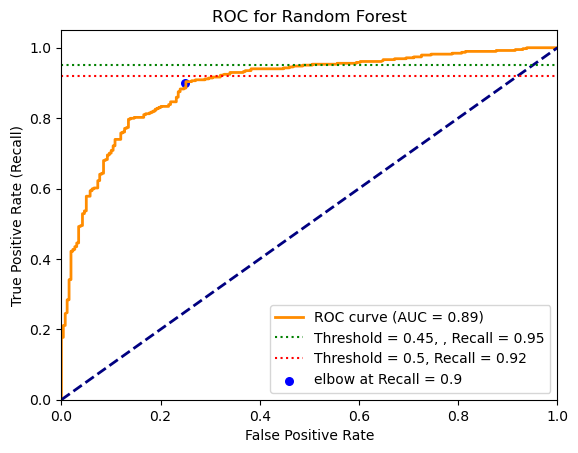

In [57]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.axhline(y=0.95, color='green', linestyle='dotted', label='Threshold = 0.45, , Recall = 0.95')
plt.axhline(y=0.92, color='red', linestyle='dotted', label='Threshold = 0.5, Recall = 0.92')
plt.scatter(0.25, 0.9, c='blue', marker='o', s=30, label = 'elbow at Recall = 0.9')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC for Random Forest')
plt.legend(loc='lower right')
plt.show()

From the plot above above it is clear that if we lower the threshold further we will start to gain much more FP than TP. If anything i might even increase the threshold just a bit to fit on the elbow

In [58]:
# Lets see how F1 will change with the new lower threshold 
pl_y_17_new_threshold = []
for i in pl_y_17_proba[:,1]:
    if i >=0.4509941932860809: pl_y_17_new_threshold.append(1)
    else: pl_y_17_new_threshold.append(0)


In [59]:
# pl_y_17_new_threshold

In [60]:
d_17_new_threshold = {'Recall RF new threshold:' : metrics.recall_score(pl_y_17, pl_y_17_new_threshold), 'Recall rf:' :metrics.recall_score(pl_y_17, pl_y_pred_17_rf),
       'F1 score RF new threshold': metrics.f1_score(pl_y_17, pl_y_17_new_threshold), 'F1 score rf' : metrics.f1_score(pl_y_17, pl_y_pred_17_rf),
      'Accuracy RF new threshold' : accuracy_score(pl_y_17, pl_y_17_new_threshold), 'Accurasy rf' : accuracy_score(pl_y_17, pl_y_pred_17_rf)}

pd.DataFrame(d_17_new_threshold, columns=d_17_new_threshold.keys(), index=['value'])

,Recall RF new threshold:,Recall rf:,F1 score RF new threshold,F1 score rf,Accuracy RF new threshold,Accurasy rf
value,0.950521,0.921875,0.834286,0.861314,0.774495,0.822706


In [61]:
print(f"This means that we have identified {metrics.confusion_matrix(pl_y_17, pl_y_17_new_threshold)[0][1]} that should have looked for treatment," 
      f"but didn't, according to the New threshold RF model. According to the Random Forest model {metrics.confusion_matrix(pl_y_17, pl_y_pred_17_rf)[0][1]} should have looked for treatment")

This means that we have identified 126 that should have looked for treatment,but didn't, according to the New threshold RF model. According to the Random Forest model 84 should have looked for treatment


[TOP](#topi)
<a id = 'pickle'></a>
## Create pickle file

In [62]:
pickle.dump(pipe_svc_17, open('SVC_model.pkl','wb'))
pickle.dump(pipe_rf_17, open('RandomForest_model.pkl','wb'))

In [63]:
test_svc = pickle.load(open('SVC_model.pkl','rb'))
test_rf = pickle.load(open('RandomForest_model.pkl','rb'))

In [64]:
# the bellow true statement makes sure all predictions using the pickle file are the same as the predictions using the model 
# saved in the pickle file. 
all(test_svc.predict(pl_X_17) == pl_y_pred_17_svc) == all(test_rf.predict(pl_X_17) == pl_y_pred_17_rf)

True

[TOP](#topi)
<a id='online-learn'></a>

## Incremental learning

According to [6.1.3. Incremental learning](https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning) there is a list of incremental estimators for Classification:<br>
* sklearn.naive_bayes.MultinomialNB
* sklearn.naive_bayes.BernoulliNB
* sklearn.linear_model.Perceptron
* sklearn.linear_model.SGDClassifier
* sklearn.linear_model.PassiveAggressiveClassifier

we will use the variables we used to create a pipeline for 2017: <br>
pl_X_old , pl_y_old <br>
pl_X_17, pl_y_17 
<br><br>
It is not possible to directly use partial_fit on a pipeline but with some help from [stackOverflow](https://stackoverflow.com/questions/17931865/using-partial-fit-with-scikit-pipeline) we found a way.<br>
For this test we will use BernoulliNB as it is suitable for binary/boolean features, and our OneHotEncoded features are just that.
<br>
We will use Grid search

In [65]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# il_parameters = {'alpha' : [0,0.2,0.5,0.7,1], 'fit_prior' : (True, False)}
# sgd_model = BernoulliNB(force_alpha = True)
# gs_il = GridSearchCV(sgd_model, il_parameters, scoring = ['recall', 'f1'], refit = 'recall')
# gs_il.fit(X_train, y_train)

GridSearchCV(estimator=BernoulliNB(force_alpha=True),
             param_grid={'alpha': [0, 0.2, 0.5, 0.7, 1],
                         'fit_prior': (True, False)},
             refit='recall', scoring=['recall', 'f1'])

In [66]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# print(f'Best Recall score = {gs_il.best_score_} , achieved with the following model on the training data:') 
# gs_il.best_estimator_

In [67]:
# ###########  the code bellow is commented in order to be loose time when the code is rerun ##########
# y_il = gs_il.predict(X_test)
# print(f'On the Test set this model achieved:\n Recall = {metrics.recall_score(y_test, y_il)}\n'
#     f' F score = {metrics.f1_score(y_test, y_il)}\n Accuracy = {metrics.accuracy_score(y_test, y_il)}')

Then using this model will create a pipeline

In [68]:
# sgd_model = SGDClassifier()
BNB_model = BernoulliNB(alpha=0, force_alpha=True)
BNB_pipe= tomi_make_pipe(used_cols_17,BNB_model)
# we will fit our model on the data from 2014 and 2016
BNB_pipe.fit(pl_X_old, pl_y_old)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender', 'family_history',
                                                   'no_employees', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'anonymity', 'leave',
                                                   'coworkers', 'supervisor',
                                                   'phys_health_interview',
                                                   'work_treatment_interfere',
                                                   'work_no_treatment_interfere',
                                                   'Continent'])])),
                ('est', BernoulliNB(alpha=0, force_alpha=True))])

In [69]:
# we will split the data from 2017 into 2 sets, and will use Incremental learning on the first and test on the second.
il_X_train, il_X_test, il_y_train, il_y_test = train_test_split(pl_X_17,pl_y_17, random_state=42, test_size= 0.25)

In [70]:
#  as we want to compare if the Incremental learning has brought us better scores 
#  we will make a prediction also with the model trained only on 2014 and 2016
pl_y_pred_17_BNB = BNB_pipe.predict(il_X_test)

In [71]:
# Apply partial fit
partial_pipe_fit(BNB_pipe,il_X_train,il_y_train)

In [72]:
pl_y_pred_17_BNB_partial = BNB_pipe.predict(il_X_test)
d_BNB= {'Recall BernoulliNB:' : metrics.recall_score(il_y_test, pl_y_pred_17_BNB), 'Recall BernoulliNB_partial:' :metrics.recall_score(il_y_test, pl_y_pred_17_BNB_partial),
       'F1 score BernoulliNB': metrics.f1_score(il_y_test, pl_y_pred_17_BNB), 'F1 score BernoulliNB_partial' : metrics.f1_score(il_y_test, pl_y_pred_17_BNB_partial),
      'Accuracy BernoulliNB' : accuracy_score(il_y_test, pl_y_pred_17_BNB), 'Accurasy BernoulliNB_partial' : accuracy_score(il_y_test, pl_y_pred_17_BNB_partial)}
pd.DataFrame(d_BNB, columns=d_BNB.keys(), index=['value'])

,Recall BernoulliNB:,Recall BernoulliNB_partial:,F1 score BernoulliNB,F1 score BernoulliNB_partial,Accuracy BernoulliNB,Accurasy BernoulliNB_partial
value,0.915789,0.915789,0.892308,0.896907,0.869565,0.875776


this results do not show significant improvement, and to be honest during my tests there were moments that the scores actually dropped a bit, but still Incremental learning is good choice.<br>
Bellow i will try to show example of what could be practically useful in this project, suggesting help to a potentially vulnerable person.

In [73]:
for i in range(len(il_y_test)):
    if BNB_pipe.predict(il_X_test.iloc[i:i+1]) == 1 and il_y_test[i] == 0:
        print('Hi, thank you for filling the servey.')
        print(f'Please consider reaching out to our team or check our list of mental health Specialists in your area ({list(il_X_test.iloc[i:i+1].Continent)[0] })')
        print('The first meeting and cosultation are free as a gratitude for filling this survey!')
        break

Hi, thank you for filling the servey.
Please consider reaching out to our team or check our list of mental health Specialists in your area (Europe)
The first meeting and cosultation are free as a gratitude for filling this survey!


[TOP](#topi)
<a id='con'></a>
## Conclusion

As our goal is to identify people who might need help but haven't looked for, i feel content with the results from this project.
All of the participants who are in the False Positive category (meaning our model believes they have looked for help, but in reality they haven't) can be notified at the end of the survey that they can look for help in their local country/state (example of this is just above).<br>
This would require the implementation of this model, maybe by implementing some API architecture. I still don't know how to do that, but this is what i managed to do so far, given the time and knowledge i have.

Also depending on how worried are we to spam people we can choose SVC or Random forest as a model for implementation.